# Data Cleaning Notebook

This data set came from a Mexican Government [website](https://www.gob.mx/salud/documentos/datos-abiertos-152127). I found a link to this dataset in a [kaggle](https://www.kaggle.com/tanmoyx/covid19-patient-precondition-dataset) project that somebody has done. I thought that finding COVID data would be easier than this, but it turns out that HIPPA laws do not allow data on the individual patient level to be made available to the public even if their names are left out. Therefore, only summary level data sets (like by county, or by age group) are able to be viewed by the public. This data set from the Mexican Government is at the individual patient level and doesn't provide any patient identification information.

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#cd ..

In [3]:
#import the data set
covid_data = pd.read_csv('Data/201001COVID19MEXICO.csv')

The original data set has 1,048,575 observations and 35 features. Also the column names are all in Spanish.

# Spanish to English Translations

The kaggle project author has done translations of the feature descriptions so I will first create a dictionary containing all column names with the key being the Spanish, and the value being the English translation. Then I am going to change the column names to the English translations.

In [4]:
translation_dict = {
    'FECHA_ACTUALIZACION': 'Update Date',
    'ID_REGISTRO': 'Record ID',
    'ORIGEN':'Origin',
    'SECTOR': 'Sector',
    'ENTIDAD_UM':'Entity Location',
    'SEXO':'Sex',
    'ENTIDAD_NAC':'Entity of Birth',
    'ENTIDAD_RES':'Entity of Residence',
    'MUNICIPIO_RES':'Residence Municipality',
    'TIPO_PACIENTE':'Type of Care',
    'FECHA_INGRESO':'Admission Date',
    'FECHA_SINTOMAS':'Sympton Onset',
    'FECHA_DEF':'Date of Death',
    'INTUBADO':'Intubation Required',
    'NEUMONIA':'Pneumonia',
    'EDAD':'Age',
    'NACIONALIDAD':'Nationality',
    'EMBARAZO':'Pregnant',
    'HABLA_LENGUA_INDIG':'Speak Indigenous',
    'DIABETES':'Diabetes',
    'EPOC':'COPD Diagnosis',
    'ASMA':'Asthma',
    'INMUSUPR':'Immunosuppression',
    'HIPERTENSION':'Hypertension',
    'OTRA_COM':'Other Diseases',
    'CARDIOVASCULAR':'Cardiovascular Disease',
    'OBESIDAD':'Obesity',
    'RENAL_CRONICA':'Kidney Failure',
    'TABAQUISMO':'Smoker',
    'OTRO_CASO':'Contact',
    'RESULTADO':'Test Result',
    'MIGRANTE':'Migrant',
    'PAIS_NACIONALIDAD':'Prior Nationality',
    'PAIS_ORIGEN':'Prior Origin',
    'UCI':'Intensive Care Needed'
}

In [5]:
#now I'm going to change the names to be in English using the dictionary above
english_names = [translation_dict[x] for x in covid_data.columns]
covid_data.columns = english_names

# Cleaning the Data

First, I am only interested in observations that actually tested positive for Covid19, so I will drop all rows where 'Test Result' is 2 (Negative) or 3 (Pending).

In [6]:
indeces_to_delete = []
for i in range(len(covid_data['Test Result'])):
    if covid_data['Test Result'][i] == 3:
        indeces_to_delete.append(i)
    elif covid_data['Test Result'][i] == 2:
        indeces_to_delete.append(i)
#now to drop the rows that didn't test positive for Covid, and then reset the index
covid_data = covid_data.drop(indeces_to_delete)
covid_data = covid_data.reset_index(drop=True)

I found that the mapping provided with the data set does not completely identify all combinations of municpalities within entity. Because of this, as well as there being over 2,000 municipalities, I have decided to get rid of this feature. I am confident that whatever information is lost from this deletion will be replaced from the 'Entity of Residence' feature which shows which state the patient lives in.

In [7]:
del covid_data['Residence Municipality']

At this point, there are ALOT of columns. I've gone through these columns and evaluated the quality of the data in them. By this, I mean I looked at how complete each column is in terms of how many N/A values are present.<br>
a. "Prior Origin" and "Migrant" features have over 700,000 N/A values each. After step 1 above, there are only 703,973 observations. Since 700,000 is over 90% of the observations, these two columns will be delete. <br>
b. "Contact" feature has over 1/7 of it's observations being N/A. This feature seems more helpful for a tracing project, and whether or not the person had come in contact with a COVID patient doesn't change the fact they have COVID. This feature will be deleted too. <br>
c. "Speak Indegenous" feature has over 22,000 N/A values. Also, this feature seems pretty useless because a virus doesn't care what language you speak. This feature will be deleted too.<br>

In [8]:
del covid_data['Migrant']
del covid_data['Prior Origin']
del covid_data['Contact']
del covid_data['Speak Indigenous']

Then there are some more complicated features: <br>
"Entity of Birth", "Diabetes", "COPD Diagnosis", "Asthma", "Immunosuppression", "Hypertension", "Other Diseases", "Cardiovascular Disease", "Obesity", "Kidney Failure", and "Smoker" features all have roughly 1,900-2,100 N/A values each. After finding out what the overlap is, there is a total of 7,185 rows where atleast one of the features are N/A. This is less than 1% of the total number of observations. Therefore, I think it should be ok to simply delete the observations where one or more of these features has N/A. Also, when considerig this, I saw that 6,008 of the observations impacted by this deletion are patient that didn't die. This shows that 83.6% of the patients deleted here didn't die. When looking at the data as a whole, 89.4% of the observations didn't die. Since 83.6% is relatively close to 89.4%, I don't think that deleting these 7,185 rows is deleting observations that offer something special to the data. Therefore, I will delete these occurences. <br>

In [9]:
vars_of_interest = ["Entity of Birth", "Diabetes", "COPD Diagnosis", "Asthma", "Immunosuppression", "Hypertension", 
                    "Other Diseases", "Cardiovascular Disease", "Obesity", "Kidney Failure", "Smoker"]
row_deletions = []
exclusion_values = [97,98,99]
for i in range(len(covid_data['Record ID'])):
    delete_row = False
    for var in vars_of_interest:
        if covid_data[var][i] in exclusion_values:
            delete_row = True
    if delete_row:
        row_deletions.append(i)

In [10]:
covid_data = covid_data.drop(row_deletions)
covid_data = covid_data.reset_index(drop=True)

After performing the above actions, there are 7 N/A values in the "Pneumonia" feature. 7 observations is incredibly small for this data set, so I will delete these observations.

In [11]:
pneumonia_delete_rows = list(covid_data[covid_data['Pneumonia']==99].index)

covid_data = covid_data.drop(pneumonia_delete_rows)
covid_data = covid_data.reset_index(drop=True)

"Pregnant" feature has 368,300 N/A values. Many of these are from patients being Male, which makes sense because men can't get pregnant. For these 365,860 observations that are Male, I will change the Pregnant feature to equal 2. For the remaining 2,440 N/A values, I will assign a 2 (for not pregnant) since out of the 335,673 women (not including the N/As), only 5,201 are pregnant. This means that for each N/A value, there is only a 1.55% chance that observation is pregnant. My approach is a "Majority takes all" approach of solving this N/A problem.

In [12]:
new_pregnant_column = []
for i in range(len(covid_data['Record ID'])):
    if covid_data['Pregnant'][i] in [97,98]:
        new_pregnant_column.append(2)
    else:
        new_pregnant_column.append(covid_data['Pregnant'][i])
covid_data['Pregnant'] = new_pregnant_column

Since whether or not someone needed intubation or intensive care seems more like potential target variables than risk factors, and the intended purpose is for assessing initial risk, I will delete the 'Intensive Care Needed' and 'Intubation Required' features.

In [13]:
del covid_data['Intensive Care Needed']
del covid_data['Intubation Required']

Whether or not a person died can be gathered from the 'Date of Death' variable. If the value is a date, then unfortunately that person died. However, if the value is '9999-99-99', then the person did not die. With this information, I'm going to create a binary variable called 'Died' which shows whether a patient died (1) or not (0). While I am looping through the data to create this new variable, I will overwrite the 'Date of Death' variable so that '9999-99-99' is recorded as np.nan.

In [14]:
died = []
death_date = []
for i in range(len(covid_data['Date of Death'])):
    if str(covid_data['Date of Death'][i]) == '9999-99-99':
        died.append(0)
        death_date.append(np.nan)
    else:
        died.append(1)
        death_date.append(covid_data['Date of Death'][i])
covid_data['Died'] = died
covid_data['Date of Death'] = death_date

In [15]:
del died
del death_date

Now that missing values are taken care of, I would like to look into a location based feature and do groupings. The one that pops out to me the most is "Entity of Residence" because this is the most current location for that person. Birth entity doesn't seem to be recent enough. I will also delete the other location based features besides entity of residence.

In [16]:
del covid_data['Entity Location']
del covid_data['Entity of Birth']

In [17]:
#I will find the unique values for an entity and then visualize how the death rate
#vary across the entities in order to define the super groups.
#First I want to create a dictionary of the death rate
unique_entities = np.unique(covid_data['Entity of Residence'])
death_entity_dict = {key: None for key in unique_entities}

for entity in unique_entities:
    entity_subset = covid_data[covid_data['Entity of Residence']==entity]
    death_entity_dict[entity] = sum(entity_subset['Died'])/max(1,len(entity_subset['Died']))

In [18]:
#I want to sort these dictionaries in terms of their rates to make it easier to create groupings from the bar chart
sorted_entity_death_dict = {k: v for k, v in sorted(death_entity_dict.items(), key=lambda item: item[1])}

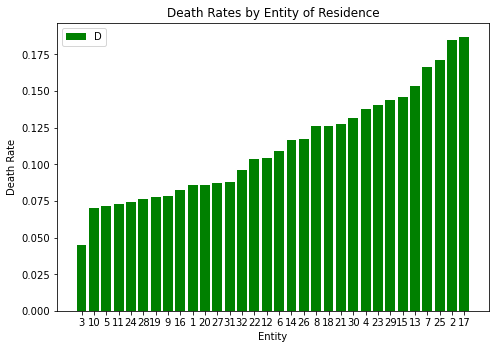

In [19]:
fig = plt.figure()
width = 0.8
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(0,len(list(sorted_entity_death_dict.keys()))),list(sorted_entity_death_dict.values()),width=width,color='green')
ax.legend(('Death Rates'))
plt.xticks(ticks=np.arange(0,len(list(sorted_entity_death_dict.keys()))),labels=list(sorted_entity_death_dict.keys()))
plt.title('Death Rates by Entity of Residence')
plt.xlabel('Entity')
plt.ylabel('Death Rate')
#plt.savefig('Residence_Entity_Death_Rates.png',bbox_inches='tight')
plt.show()

In [20]:
#This entity_groupings dictionary will contain the mapping from entity to supergroup for entity of residence
#I picked 0.09 as the first cutoff because that roughly looks like the cutoff for the lowest third of the data
#I picked 0.13 as the second cutoff because that seems like the rough cutoff for the highest third of the data
entity_groupings = {}
for key in list(sorted_entity_death_dict.keys()):
    if sorted_entity_death_dict[key] < 0.09:
        entity_groupings[int(key)] = 1
    elif 0.09 <= sorted_entity_death_dict[key] <=0.13:
        entity_groupings[int(key)] = 2
    else:
        entity_groupings[int(key)] = 3

In [21]:
#now to map these definitions to the dataframe
new_column = []
for i in range(len(covid_data['Entity of Residence'])):
    current_entity = covid_data['Entity of Residence'][i]
    if current_entity not in exclusion_values:
        new_column.append(entity_groupings[current_entity])
    else:
        #I need to make it a 99 because otherwise np.nan will pop up lots of times in the np.unique when doing encoding.
        #Having a np.nan as 99 will be easier later than having it as either 97,98,or 99.
        new_column.append(99)
covid_data["Entity of Residence Grouped"] = new_column

In [22]:
#now that the grouping is done, I can get rid of the old pregrouped feature. I can also get rid of the variables set up during
#the time to free up memory space
del covid_data['Entity of Residence']
del death_entity_dict
del entity_subset
del sorted_entity_death_dict
del new_column

In [23]:
#there are a few left over features not representing risk factors that won't be necessary for analysis later on in the 
#project. Therefore, I will delete them before encoding
variables_to_delete = ['Update Date','Record ID','Origin','Sector','Type of Care','Admission Date','Sympton Onset',
                       'Date of Death','Nationality','Test Result','Prior Nationality']
for var in variables_to_delete:
    del covid_data[var]

In [24]:
#Lastly, for all the features that are types of conditions, the value ranges of 1-2 need to change to 0-1. This can be done
#by simply changing all occurences of 2 to 0 for these variables
yes_no_vars = ['Pneumonia','Pregnant','Diabetes','COPD Diagnosis','Asthma','Immunosuppression','Hypertension','Other Diseases',
              'Cardiovascular Disease','Obesity','Kidney Failure','Smoker','Died']
covid_data[yes_no_vars] = covid_data[yes_no_vars].replace(2,0)

### Writing the Final Cleaned Data to a CSV File

In [25]:
covid_data.to_csv('Data/CleanedCovidData10-16.csv',index=False)

# Value Mapping <br>
Most data fields in this data set have numeric representations for non-numeric values.

Below are dictionaries I have created using the 'Catalogos_0412.csv' file provided with the Covid data.

In [26]:
#dictionary of yes/no features
yes_no_dict = dict(zip([0,1],['No','Yes']))

#dictionary of entity names associated with each numeric value in the data
entity_numbers = range(1,37,1)
entity_names = ['AGUASCALIENTES','BAJA CALIFORNIA','BAJA CALIFORNIA SUR','CAMPECHE','COAHUILA DE ZARAGOZA','COLIMA','CHIAPAS',
'CHIHUAHUA','CIUDAD DE MÉXICO','DURANGO','GUANAJUATO','GUERRERO','HIDALGO','JALISCO','MÉXICO','MICHOACÁN DE OCAMPO',
'MORELOS','NAYARIT','NUEVO LEÓN','OAXACA','PUEBLA','QUERÉTARO','QUINTANA ROO','SAN LUIS POTOSÍ','SINALOA','SONORA',
'TABASCO','TAMAULIPAS','TLAXCALA','VERACRUZ DE IGNACIO DE LA LLAVE','YUCATÁN','ZACATECAS','ESTADOS UNIDOS MEXICANOS']
entity_dict = dict(zip(entity_numbers,entity_names))

value_mapping_dict={
    'Sex':dict(zip([1,2],['Female','Male'])),
    'Entity of Residence':entity_dict,
    'Entity of Residence Grouped':entity_groupings,
    'Pneumonia':yes_no_dict,
    'Age':{},
    'Pregnant':yes_no_dict,
    'Diabetes':yes_no_dict,
    'COPD Diagnosis':yes_no_dict,
    'Asthma':yes_no_dict,
    'Immunosuppression':yes_no_dict,
    'Hypertension':yes_no_dict,
    'Other Diseases':yes_no_dict,
    'Cardiovascular Disease':yes_no_dict,
    'Obesity':yes_no_dict,
    'Kidney Failure':yes_no_dict,
    'Smoker':yes_no_dict,
    'Died':yes_no_dict
}

In [27]:
#now that the mappings are all created, I would like to write them to a json file
with open('Data/post_cleaning_data_mapping.json', 'w') as json_file:
    json.dump(value_mapping_dict, json_file)